In [1]:
# import the packages we will be using
import pandas as pd
import seaborn as sns
import numpy as np
# initialize the style we will use for our figures
#sns.set_theme(style="darkgrid")

In [3]:
# load the data
df = pd.read_excel("data/2024/shared_data.xlsx", sheet_name="Bioreactors", skiprows=10).drop('What', axis=1)
df.head()

Team  Vessel id                Time    Time.1  Volume  Total cell density  \
0     1          1 2024-06-11 14:21:00  4.000000     400              294000   
1     1          2 2024-06-11 14:24:00  4.050000     400              206000   
2     2          3 2024-06-11 10:49:00  0.466667     400              317000   
3     2          4 2024-06-11 10:51:00  0.500000     400              147000   
4     3          5 2024-06-11 14:10:00  0.650000     400              265000   

   Dead cell density  Viability  Live cell density  Titer  Glutamine  \
0              29400   0.900000             264600   4.33       3.76   
1                  0   1.000000             206000   3.90       3.41   
2               5880   0.981451             311120   3.92       3.88   
3               5880   0.960000             141120   3.83       3.70   
4              11800   0.955472             253200   4.40       3.95   

   Glutamate  Glucose  Lactate  Ammonium  Sodium  Potasium  Calcium  
0       2.09     5.83     0.18      0.79   119.1      9.22     0.27  
1       2.15     5.89     0.16      0.67   118.1      9.30     0.27  
2       2.17     5.88     0.13      0.65   120.5      9.14     0.28  
3       2.17     5.90     0.13      0.63   117.9      9.20     0.28  
4       2.21     6.10     0.15      0.68   122.8      9.53     0.29

In [4]:
# verify the data types
df.dtypes

Team                           int64
Vessel id                      int64
Time                  datetime64[ns]
Time.1                       float64
Volume                         int64
Total cell density             int64
Dead cell density              int64
Viability                    float64
Live cell density              int64
Titer                        float64
Glutamine                    float64
Glutamate                    float64
Glucose                      float64
Lactate                      float64
Ammonium                     float64
Sodium                       float64
Potasium                     float64
Calcium                      float64
dtype: object

In [5]:
# lets switch the reactor id to be a string. Otherwise it will be treated as a continues variable which will be undesirable in certain situations
df['Vessel id'] = df['Vessel id'].apply(lambda x: f"u{x}")
# lets also create a delta time in days instead of hours
df['days'] = df['Time.1']/24

In [6]:
def specific_growth_rate(g):
    g = g.sort_values(by='Time.1')
    sgr = pd.Series([0, *[np.log(g['Live cell density'].iloc[i+1]/g['Live cell density'].iloc[i])/((g['Time.1'].iloc[i+1]-g['Time.1'].iloc[i])/24) for i in range(len(g)-1)]])
    sgr.index = g.index
    g['sgr [day^-1]'] = sgr
    return g

def doubling_time(g):
    #=((A7-A6)*LN(2))/LN(D7/D6)
    g = g.sort_values(by='Time.1')
    dt = pd.Series([0, *[((g['Time.1'].iloc[i+1]-g['Time.1'].iloc[i])*np.log(2))/np.log(g['Live cell density'].iloc[i+1]/g['Live cell density'].iloc[i]) for i in range(len(g)-1)]])
    dt.index = g.index
    g['doubling time [h]'] = dt
    return g
        
df = df.groupby("Vessel id").apply(specific_growth_rate, include_groups=False).reset_index().drop('level_1', axis=1)
df = df.groupby("Vessel id").apply(doubling_time, include_groups=False).reset_index().drop('level_1', axis=1)
df.head()

Vessel id  Team                Time      Time.1  Volume  Total cell density  \
0        u1     1 2024-06-11 14:21:00    4.000000     400              294000   
1        u1     1 2024-06-12 09:55:00   23.566667     390              799000   
2        u1     1 2024-06-13 09:46:00   47.416667     380             1366400   
3        u1     1 2024-06-14 09:52:00   71.516667     375             2000000   
4        u1     1 2024-06-17 09:52:00  143.516667     370             6680000   

   Dead cell density  Viability  Live cell density  Titer  ...  Glutamate  \
0              29400   0.900000             264600   4.33  ...       2.09   
1              17600   0.977972             781400   7.29  ...       2.28   
2              76400   0.944087            1290000  11.50  ...       2.44   
3                  0   1.000000            2000000  17.20  ...       2.74   
4              17000   0.997455            6663000  21.40  ...       4.73   

   Glucose  Lactate  Ammonium  Sodium  Potasium  Calcium      days  \
0     5.83     0.18      0.79   119.1      9.22     0.27  0.166667   
1     5.83     0.26      1.48   120.1      9.26     0.28  0.981944   
2     5.56     0.42      2.77   121.0      9.30     0.28  1.975694   
3     4.96     0.70      4.96   122.0      9.19     0.27  2.979861   
4     2.39     1.96     14.96   125.6      9.32     0.23  5.979861   

   sgr [day^-1]  doubling time [h]  
0      0.000000           0.000000  
1      1.328220          12.524685  
2      0.504463          32.976701  
3      0.436685          38.095001  
4      0.401141          41.470548  

[5 rows x 21 columns]

In [7]:
df.columns

Index(['Vessel id', 'Team', 'Time', 'Time.1', 'Volume', 'Total cell density',
       'Dead cell density', 'Viability', 'Live cell density', 'Titer',
       'Glutamine', 'Glutamate', 'Glucose', 'Lactate', 'Ammonium', 'Sodium',
       'Potasium', 'Calcium', 'days', 'sgr [day^-1]', 'doubling time [h]'],
      dtype='object')

In [8]:
long_format = df[['Vessel id', 'days', 'Live cell density', 'Viability', 'sgr [day^-1]', 'doubling time [h]', 'Glutamine', 'Glutamate', 'Glucose', 'Lactate', 'Ammonium', 'Sodium', 'Potasium', 'Calcium', 'Titer']].melt(id_vars=['Vessel id', 'days'])
long_format.head()

Vessel id      days           variable      value
0        u1  0.166667  Live cell density   264600.0
1        u1  0.981944  Live cell density   781400.0
2        u1  1.975694  Live cell density  1290000.0
3        u1  2.979861  Live cell density  2000000.0
4        u1  5.979861  Live cell density  6663000.0

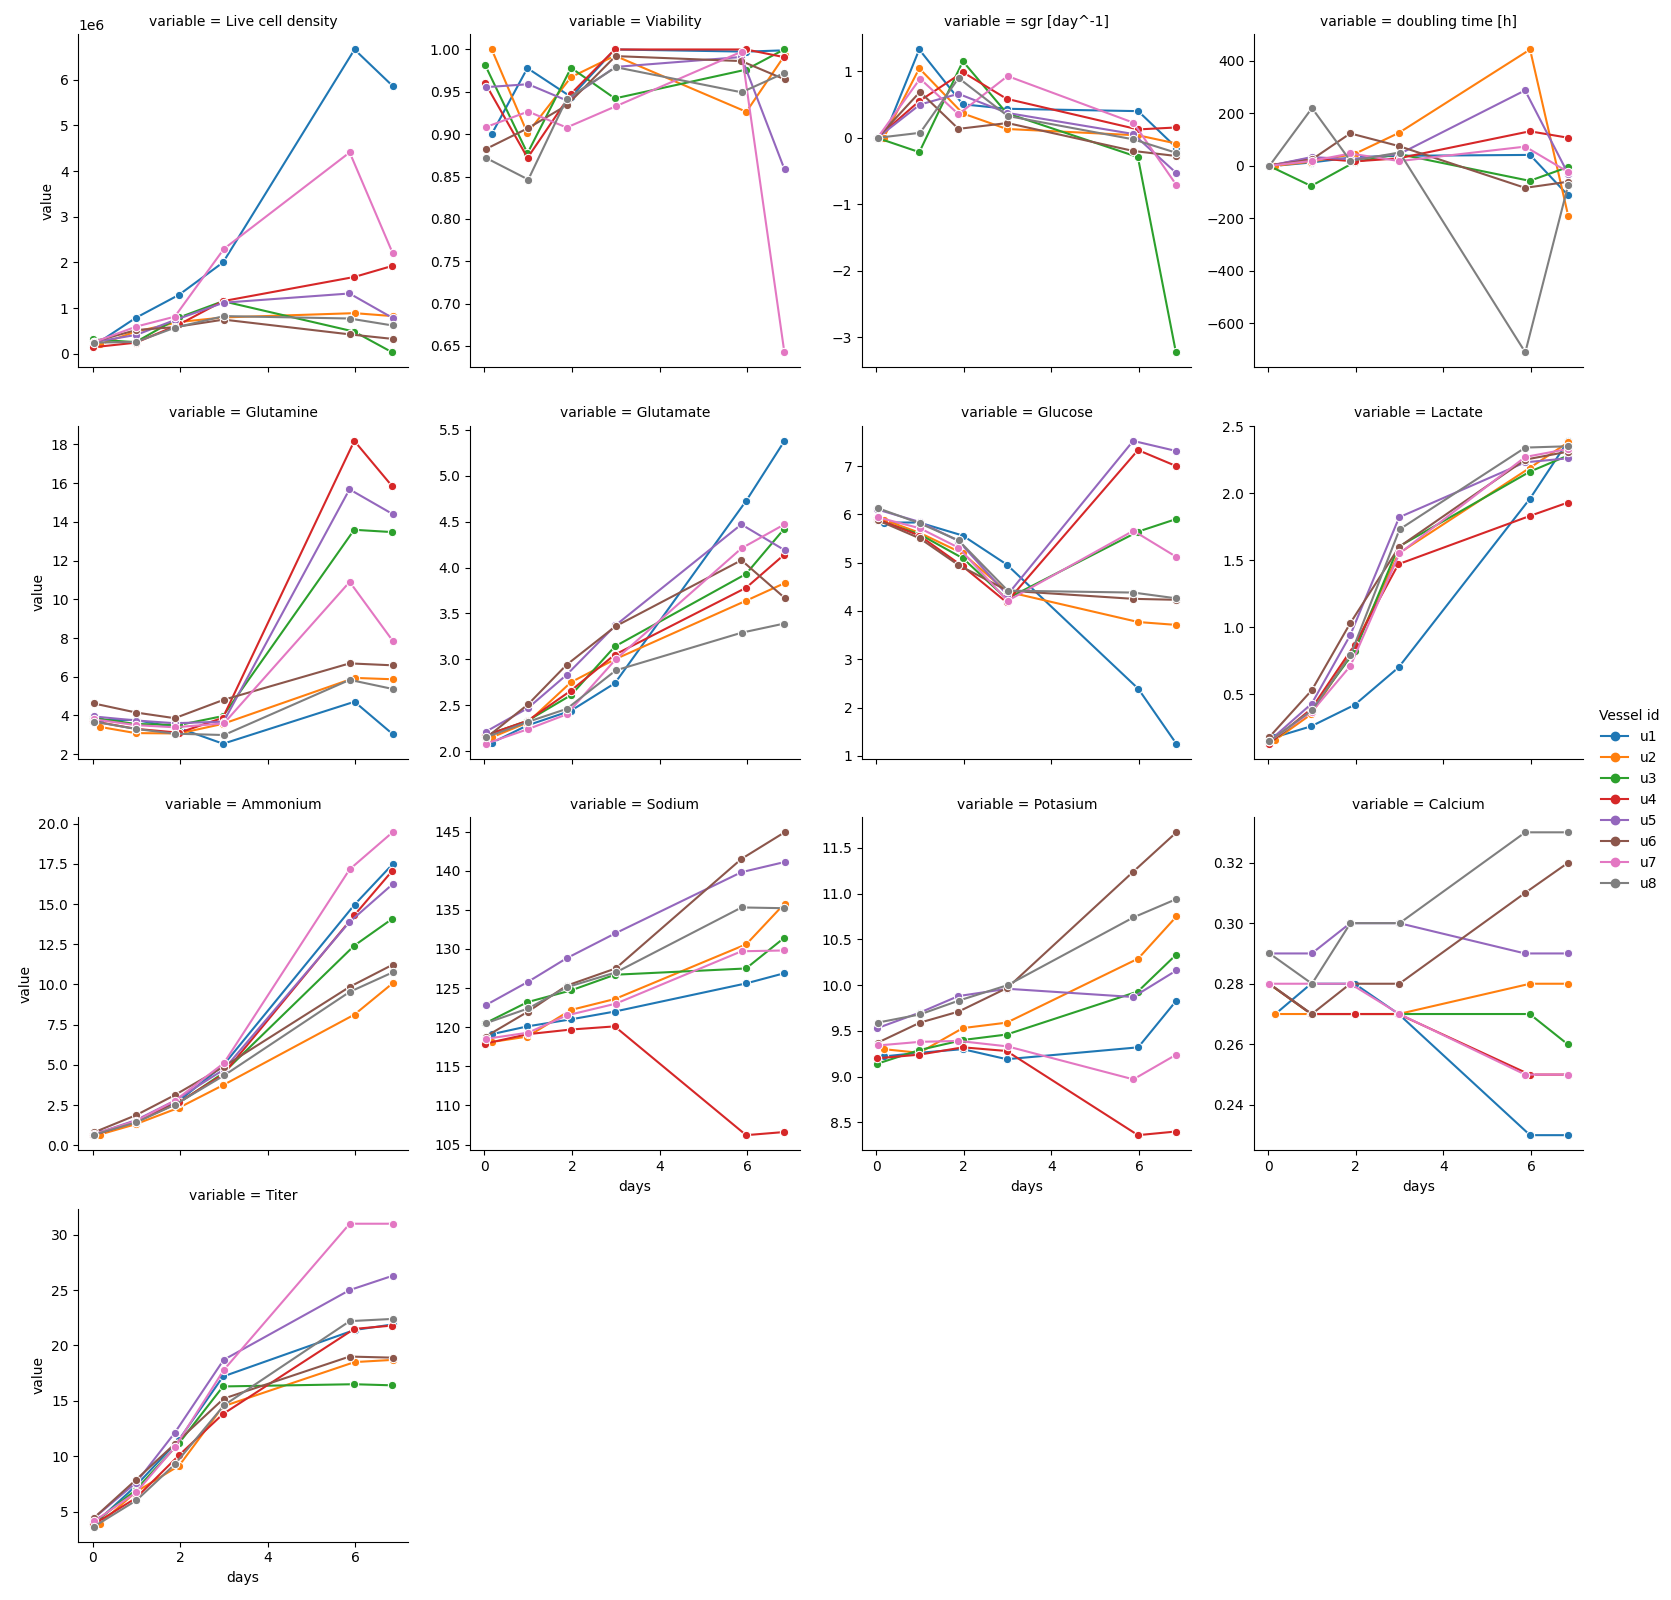

In [9]:
sns.relplot(data=long_format, x="days", y='value', hue='Vessel id', col='variable', col_wrap=4, facet_kws={'sharey': False, 'sharex': True}, kind='line', marker='o', height=4)

In [10]:
def ivcd(g):
    g = g.sort_values(by='days')
    ivcd = pd.Series([0, *[0.5*(g['Live cell density'].iloc[i+1]+g['Live cell density'].iloc[i])*g['Volume'].iloc[i]*((g['days'].iloc[i+1]-g['days'].iloc[i])/24) for i in range(len(g)-1)]])
    ivcd.index = g.index
    g['ivcd [cell*day]'] = ivcd
    return g

df = df.groupby("Vessel id").apply(ivcd, include_groups=False).reset_index().drop('level_1', axis=1)

In [11]:
def pcd(g):
    g = g.sort_values(by='days')
    pcd = pd.Series([0, *[((g['Titer'].iloc[i+1]-g['Titer'].iloc[i])*g['Volume'].iloc[i]*1E3)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    pcd.index = g.index
    g['pcd [pg/cell/day]'] = pcd
    return g

df = df.groupby("Vessel id").apply(pcd, include_groups=False).reset_index().drop('level_1', axis=1)

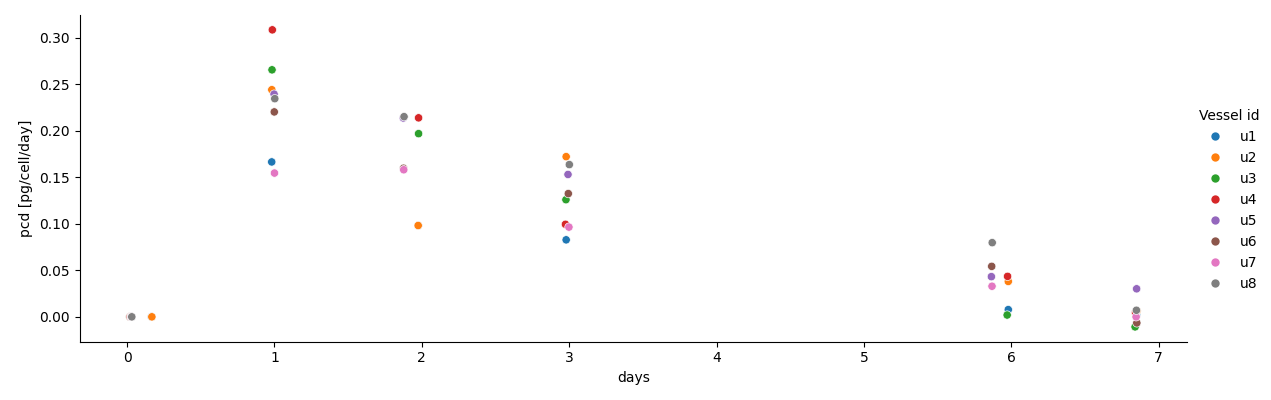

In [12]:
sns.relplot(data=df, hue="Vessel id", y="pcd [pg/cell/day]", kind='scatter', x='days', height=4, aspect=3)

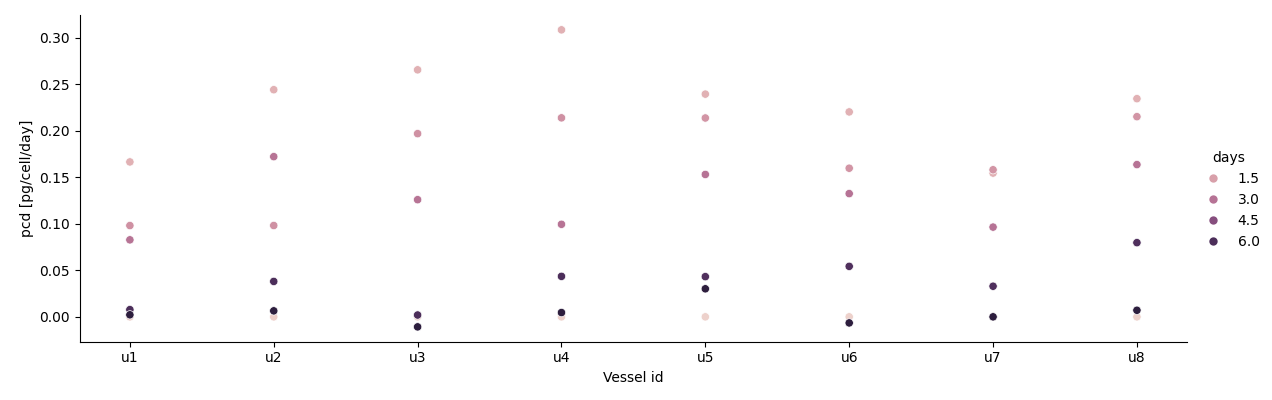

In [13]:
sns.relplot(data=df, x="Vessel id", y="pcd [pg/cell/day]", kind='scatter', hue='days', height=4, aspect=3)

In [14]:
# NON FED 'Glu','Lac', 'NH4+', 'Na+', 'K+','IgG [mg/mL]', 

def spec_proc_non_fed(g):
    g = g.sort_values(by='days')
    spec_proc_glu = pd.Series([0, *[((g['Glutamate'].iloc[i+1]-g['Glutamate'].iloc[i])*g['Volume'].iloc[i]*1E6)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    spec_proc_lac = pd.Series([0, *[((g['Lactate'].iloc[i+1]-g['Lactate'].iloc[i])*g['Volume'].iloc[i]*1E6)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    spec_proc_nh4 = pd.Series([0, *[((g['Ammonium'].iloc[i+1]-g['Ammonium'].iloc[i])*g['Volume'].iloc[i]*1E6)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    spec_proc_na = pd.Series([0, *[((g['Sodium'].iloc[i+1]-g['Sodium'].iloc[i])*g['Volume'].iloc[i]*1E6)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    spec_proc_k = pd.Series([0, *[((g['Potasium'].iloc[i+1]-g['Potasium'].iloc[i])*g['Volume'].iloc[i]*1E6)/g['ivcd [cell*day]'].iloc[i+1] for i in range(len(g)-1)]])
    
    spec_proc_glu.index = g.index
    spec_proc_lac.index = g.index
    spec_proc_nh4.index = g.index
    spec_proc_na.index = g.index
    spec_proc_k.index = g.index
    
    g['spec_proc (glu) [nM/cell/day]'] = spec_proc_glu
    g['spec_proc (lac) [nM/cell/day]'] = spec_proc_lac
    g['spec_proc (NH4) [nM/cell/day]'] = spec_proc_nh4
    g['spec_proc (Na+) [nM/cell/day]'] = spec_proc_na
    g['spec_proc (K+) [nM/cell/day]'] = spec_proc_k
    return g

df = df.groupby("Vessel id").apply(spec_proc_non_fed, include_groups=False).reset_index().drop('level_1', axis=1)
df.head()

Vessel id  Team                Time      Time.1  Volume  Total cell density  \
0        u1     1 2024-06-11 14:21:00    4.000000     400              294000   
1        u1     1 2024-06-12 09:55:00   23.566667     390              799000   
2        u1     1 2024-06-13 09:46:00   47.416667     380             1366400   
3        u1     1 2024-06-14 09:52:00   71.516667     375             2000000   
4        u1     1 2024-06-17 09:52:00  143.516667     370             6680000   

   Dead cell density  Viability  Live cell density  Titer  ...      days  \
0              29400   0.900000             264600   4.33  ...  0.166667   
1              17600   0.977972             781400   7.29  ...  0.981944   
2              76400   0.944087            1290000  11.50  ...  1.975694   
3                  0   1.000000            2000000  17.20  ...  2.979861   
4              17000   0.997455            6663000  21.40  ...  5.979861   

   sgr [day^-1]  doubling time [h]  ivcd [cell*day]  pcd [pg/cell/day]  \
0      0.000000           0.000000     0.000000e+00           0.000000   
1      1.328220          12.524685     7.106505e+06           0.166608   
2      0.504463          32.976701     1.672494e+07           0.098171   
3      0.436685          38.095001     2.615436e+07           0.082816   
4      0.401141          41.470548     2.030391e+08           0.007757   

   spec_proc (glu) [nM/cell/day]  spec_proc (lac) [nM/cell/day]  \
0                       0.000000                       0.000000   
1                      10.694428                       4.502917   
2                       3.730956                       3.730956   
3                       4.358738                       4.068156   
4                       3.675401                       2.327138   

   spec_proc (NH4) [nM/cell/day]  spec_proc (Na+) [nM/cell/day]  \
0                       0.000000                       0.000000   
1                      38.837659                      56.286462   
2                      30.080831                      20.986626   
3                      31.818789                      14.529128   
4                      18.469352                       6.648967   

   spec_proc (K+) [nM/cell/day]  
0                      0.000000  
1                      2.251458  
2                      0.932739  
3                     -1.598204  
4                      0.240102  

[5 rows x 28 columns]

In [15]:
long_format = df[['Vessel id', 'days', 'spec_proc (glu) [nM/cell/day]', 'spec_proc (lac) [nM/cell/day]', 'spec_proc (NH4) [nM/cell/day]', 'spec_proc (Na+) [nM/cell/day]', 'spec_proc (K+) [nM/cell/day]','pcd [pg/cell/day]']].melt(id_vars=['Vessel id', 'days'])
long_format.head()

Vessel id      days                       variable      value
0        u1  0.166667  spec_proc (glu) [nM/cell/day]   0.000000
1        u1  0.981944  spec_proc (glu) [nM/cell/day]  10.694428
2        u1  1.975694  spec_proc (glu) [nM/cell/day]   3.730956
3        u1  2.979861  spec_proc (glu) [nM/cell/day]   4.358738
4        u1  5.979861  spec_proc (glu) [nM/cell/day]   3.675401

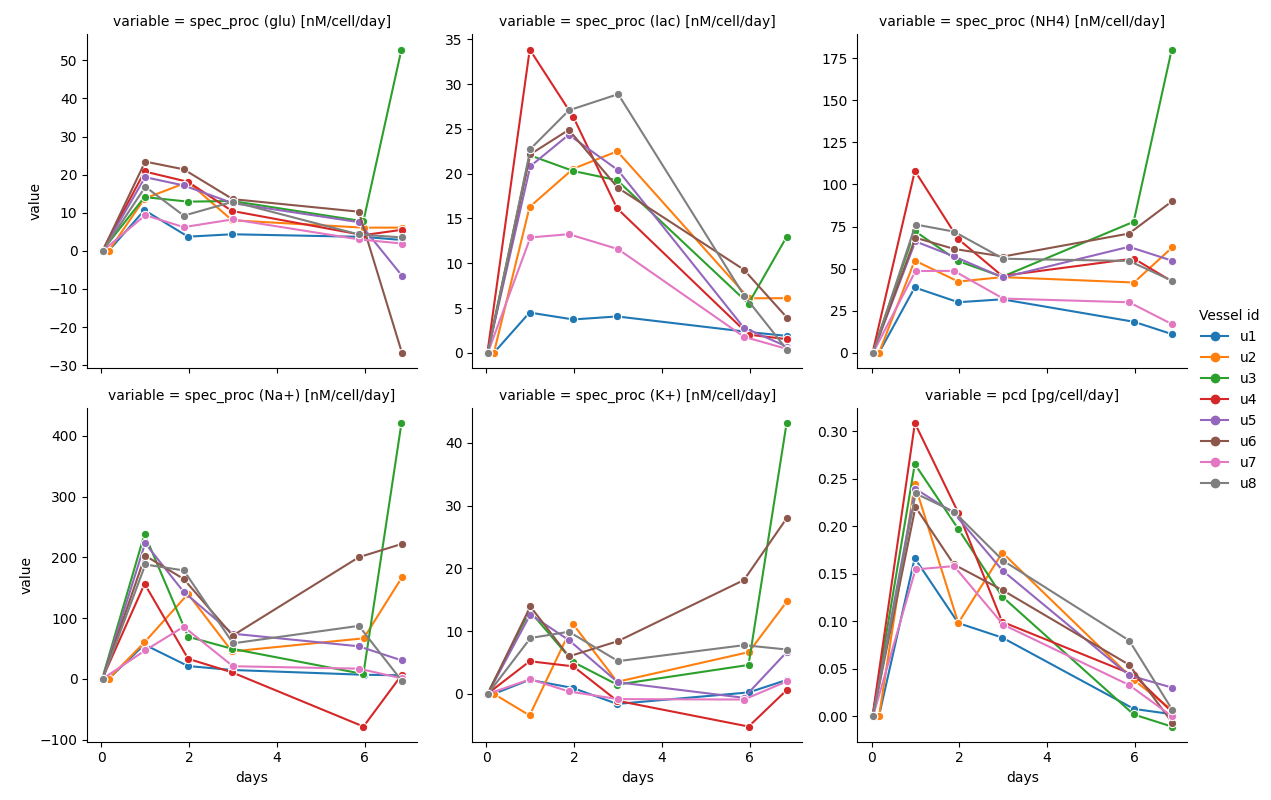

In [16]:
sns.relplot(data=long_format, x="days", y='value', hue='Vessel id', col='variable', col_wrap=3, facet_kws={'sharey': False, 'sharex': True}, kind='line', marker='o', height=4)

In [17]:
# FED 'Gln', 'Gluc', 
# 'Gluc fed [mL of 2220 mM stock]', #'Gln fed [mL of 200 mM stock]', 

#'Vessel id', 'days', 'Time [h]',    
#'sgr [day^-1]', 'doubling time [h]', 'ivcd [cell*day]',
#'pcd [pg/cell/day]'

In [17]:
gluc_stock_conc = 2220 # mM
gln_stock_conc = 200 # mM

def spec_proc_active_fed(g):
    g = g.sort_values(by='Date')
    values_gluc = [0]
    values_gln = [0]
    for i in range(len(g)-1):
        current_measurement_gluc = g['Gluc'].iloc[i] * volume_L # mmol
        current_measurement_gln = g['Gln'].iloc[i] * volume_L # mmol
        # was it fed?
        fed_ml_gluc = g['Gluc fed [mL of 2220 mM stock]'].iloc[i]
        fed_ml_gln = g['Gln fed [mL of 200 mM stock]'].iloc[i]
        if fed_ml_gluc > 0:
            #yes, then add the fed amount
            mmol_fed_gluc = fed_ml_gluc*gluc_stock_conc * 1E-3 # mL * mM * 1E-3 = mmol
            current_measurement_gluc += mmol_fed_gluc
        if fed_ml_gln > 0:
            mmol_fed_gln = fed_ml_gln*gln_stock_conc * 1E-3 # mL * mM * 1E-3 = mmol
            current_measurement_gln += mmol_fed_gln
        next_measurement_gluc = g['Gluc'].iloc[i+1] * volume_L # mmol
        next_measurement_gln = g['Gln'].iloc[i+1] * volume_L # mmol
        
        values_gluc.append(abs(((next_measurement_gluc-current_measurement_gluc)*1E6)/g['ivcd [cell*day]'].iloc[i+1]))
        values_gln.append(abs(((next_measurement_gln-current_measurement_gln)*1E6)/g['ivcd [cell*day]'].iloc[i+1]))
        
    spec_proc_gluc = pd.Series(values_gluc)
    spec_proc_gluc.index = g.index
    spec_proc_gln = pd.Series(values_gln)
    spec_proc_gln.index = g.index
    g['spec_proc (gluc) [nM/cell/day]'] = spec_proc_gluc
    g['spec_proc (gln) [nM/cell/day]'] = spec_proc_gln
    return g

df = df.groupby("Vessel id", group_keys=False).apply(spec_proc_active_fed)
df.head()

KeyError: 'Date'

In [ ]:
sns.catplot(data=df[df['days'] != 0], x="Vessel id", y="spec_proc (gluc) [nM/cell/day]", kind='swarm', hue='days', height=4, aspect=3)
sns.catplot(data=df[df['days'] != 0], x="Vessel id", y="spec_proc (gln) [nM/cell/day]", kind='swarm', hue='days', height=4, aspect=3)

In [ ]:
sns.catplot(data=df, hue="Vessel id", y="spec_proc (gluc) [nM/cell/day]", kind='swarm', x='days', height=4, aspect=3)
sns.catplot(data=df, hue="Vessel id", y="spec_proc (gln) [nM/cell/day]", kind='swarm', x='days', height=4, aspect=3)

In [18]:
#-----Predict-----#

In [19]:
# calc ivcd for next period based on previous period sgr (u)
# x(t) = x0 * e^(ut)
# u = ln(2)/dt

# time delta = 24 hours
# Scenario: We are at day 3, we want to predict day 4 in bioreactor 1

df[(df['Vessel id'] == 'u1') & (df['days'] == 3)]

Empty DataFrame
Columns: [Vessel id, Team, Time, Time.1, Volume, Total cell density, Dead cell density, Viability, Live cell density, Titer, Glutamine, Glutamate, Glucose, Lactate, Ammonium, Sodium, Potasium, Calcium, days, sgr [day^-1], doubling time [h], ivcd [cell*day], pcd [pg/cell/day], spec_proc (glu) [nM/cell/day], spec_proc (lac) [nM/cell/day], spec_proc (NH4) [nM/cell/day], spec_proc (Na+) [nM/cell/day], spec_proc (K+) [nM/cell/day]]
Index: []

[0 rows x 28 columns]

In [20]:
u = df[(df['Vessel id'] == 'u5') & (df['days'] == 3)]['sgr [day^-1]'].iloc[0]
x3 = df[(df['Vessel id'] == 'u5') & (df['days'] == 3)]['Live (cells/ml) 2'].iloc[0]
x4_pred = x3*np.e**u
x4_actual = df[(df['Vessel id'] == 'u5') & (df['days'] == 4)]['Live (cells/ml) 2'].iloc[0]
print(f"{x4_pred} <-> {x4_actual} > {x4_actual-x4_pred} ({(x4_actual-x4_pred)/x4_actual:.1%})")

IndexError: single positional indexer is out-of-bounds

In [ ]:
ivcd_pred = 0.5*(x4_pred+x3)*volume_mL
ivcd_actual = df[(df['Vessel id'] == 'u5') & (df['days'] == 4)]['ivcd [cell*day]'].iloc[0]
print(f"{ivcd_pred} <-> {ivcd_actual} > {ivcd_actual-ivcd_pred} ({(ivcd_actual-ivcd_pred)/ivcd_actual:.1%})")

In [21]:
scg = -df[(df['Vessel id'] == 'u5') & (df['days'] == 3)]['spec_proc (gluc) [nM/cell/day]'].iloc[0]
delta_gluc_3_to_4 = ivcd_pred*scg/1E6
gluc_day_3 = df[(df['Vessel id'] == 'u5') & (df['days'] == 3)]['Gluc'].iloc[0]

gluc_4_pred = gluc_day_3 + delta_gluc_3_to_4
gluc_4_actual = df[(df['Vessel id'] == 'u5') & (df['days'] == 4)]['Gluc'].iloc[0]
print(f"{gluc_4_pred} <-> {gluc_4_actual} > {gluc_4_actual-gluc_4_pred} ({(gluc_4_actual-gluc_4_pred)/gluc_4_actual:.1%})")

KeyError: 'spec_proc (gluc) [nM/cell/day]'

In [22]:
gluc_4_actual

NameError: name 'gluc_4_actual' is not defined

In [23]:
### reactor condition recommendations

In [18]:
parameters = pd.DataFrame({
    'u1': {'rpm': 80,'pH':6.8,'pO':0.2},
    'u2': {'rpm': 80,'pH':7.0,'pO':0.6},
    'u3': {'rpm': 100,'pH':7.2,'pO':0.4},
    'u4': {'rpm': 100,'pH':6.8,'pO':0.2},
    'u5': {'rpm': 120,'pH':7.0,'pO':0.6},
    'u6': {'rpm': 120,'pH':7.2,'pO':0.4},
    'u7': {'rpm': 150,'pH':6.8,'pO':0.2},
    'u8': {'rpm': 150,'pH':7.0,'pO':0.6}
})
parameters

u1    u2     u3     u4     u5     u6     u7     u8
rpm  80.0  80.0  100.0  100.0  120.0  120.0  150.0  150.0
pH    6.8   7.0    7.2    6.8    7.0    7.2    6.8    7.0
pO    0.2   0.6    0.4    0.2    0.6    0.4    0.2    0.6

In [19]:
df = df.merge(parameters.T, how='inner', left_on='Vessel id', right_index=True)

In [20]:
results = df.pivot_table(index='Vessel id', values=['rpm', 'pO', 'pH', 'Live cell density', 'Titer'], aggfunc={'rpm': "mean", 'pO': "mean", 'pH': "mean", 'Live cell density': "sum", 'Titer': "max"})
results.to_csv("pivot_res.csv")

In [21]:
results

Live cell density  Titer   pH   pO    rpm
Vessel id                                           
u1                  16863120   21.9  6.8  0.2   80.0
u2                   3885840   18.7  7.0  0.6   80.0
u3                   3019320   16.5  7.2  0.4  100.0
u4                   5774920   21.8  6.8  0.2  100.0
u5                   4616300   26.3  7.0  0.6  120.0
u6                   2856140   19.0  7.2  0.4  120.0
u7                  10568600   31.0  6.8  0.2  150.0
u8                   3280200   22.4  7.0  0.6  150.0

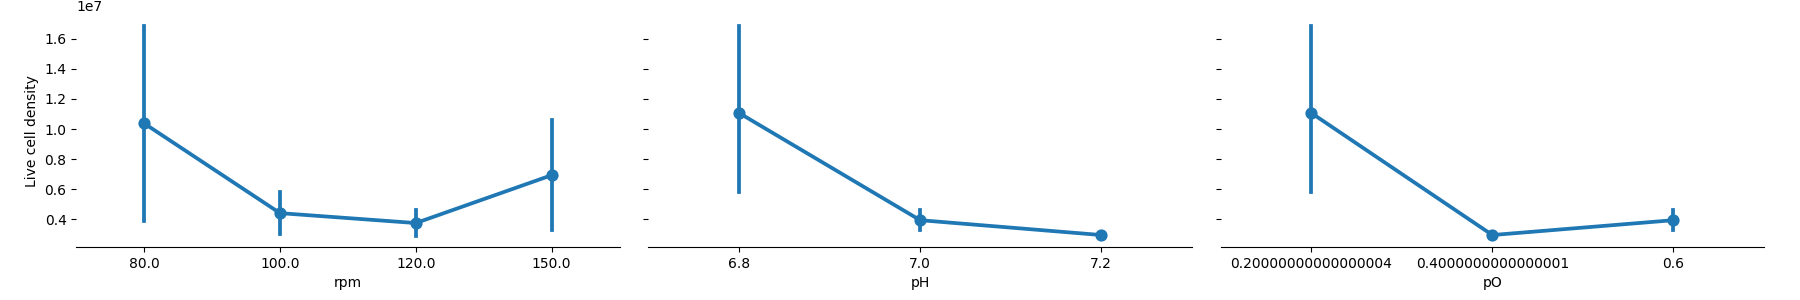

In [22]:
g = sns.PairGrid(results, y_vars="Live cell density", x_vars=["rpm", 'pH', 'pO'], height=3, aspect=2)
g.map(sns.pointplot)
sns.despine(fig=g.fig, left=True)

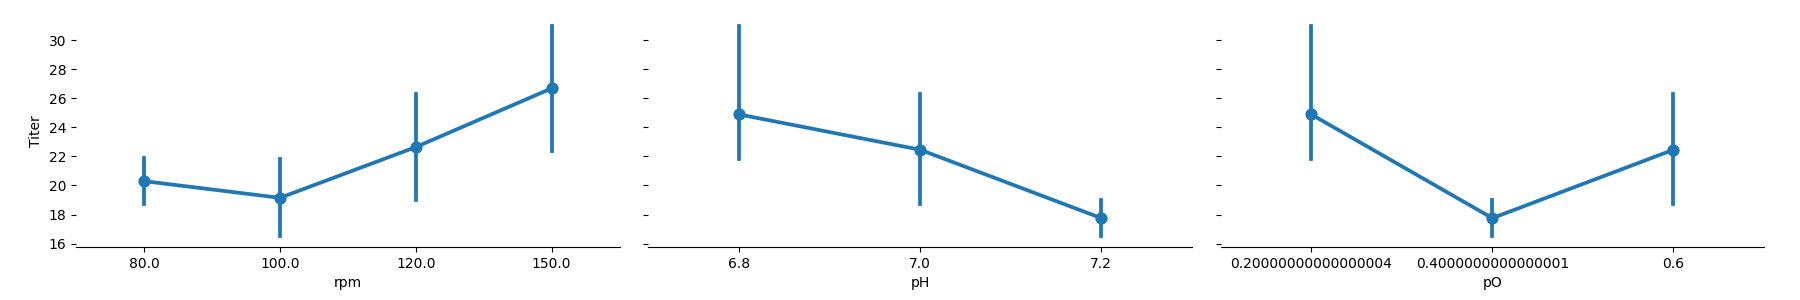

In [23]:
g = sns.PairGrid(results, y_vars="Titer", x_vars=["rpm", 'pH', 'pO'], height=3, aspect=2)
g.map(sns.pointplot)
sns.despine(fig=g.fig, left=True)

In [24]:
results

Live cell density  Titer   pH   pO    rpm
Vessel id                                           
u1                  16863120   21.9  6.8  0.2   80.0
u2                   3885840   18.7  7.0  0.6   80.0
u3                   3019320   16.5  7.2  0.4  100.0
u4                   5774920   21.8  6.8  0.2  100.0
u5                   4616300   26.3  7.0  0.6  120.0
u6                   2856140   19.0  7.2  0.4  120.0
u7                  10568600   31.0  6.8  0.2  150.0
u8                   3280200   22.4  7.0  0.6  150.0

In [25]:
df.to_csv("final.csv")

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [27]:
mod = smf.ols(formula='Titer ~ rpm + pO + pH', data=results)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Titer   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     4.756
Date:                Wed, 26 Jun 2024   Prob (F-statistic):             0.0830
Time:                        19:24:57   Log-Likelihood:                -16.988
No. Observations:                   8   AIC:                             41.98
Df Residuals:                       4   BIC:                             42.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    140.1040     53.293      2.629      0.0

/home/laeb/.pyenv/versions/scipy/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [28]:
res.get_prediction().summary_frame()

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
Vessel id                                                                    
u1         21.831646  2.031438      16.191469      27.471822     12.089862   
u2         18.716456  2.194860      12.622549      24.810363      8.705139   
u3         16.727215  2.060972      11.005038      22.449392      6.937727   
u4         23.877215  1.698098      19.162538      28.591892     14.640390   
u5         22.807595  1.656926      18.207230      27.407960     13.628590   
u6         18.772785  2.060972      13.050608      24.494962      8.983297   
u7         28.991139  2.283537      22.651023      35.331255     18.828077   
u8         25.875949  2.110642      20.015869      31.736030     16.005219   

           obs_ci_upper  
Vessel id                
u1            31.573430  
u2            28.727773  
u3            26.516703  
u4            33.114041  
u5            31.986599  
u6            28.562273  
u7            39.154202  
u8            35.746679

In [29]:
steps = 10
rpm = np.linspace(20,300, steps)
pO = np.linspace(10,100, steps)
pH = np.linspace(5,10, steps)
rrr = []
for r in rpm:
    for o in pO:
        ress = res.predict({'rpm':[r]*steps, 'pO':[o]*steps, 'pH': pH})
        rrr.append(pd.DataFrame({'rpm':[r]*steps, 'pO':[o]*steps, 'pH': pH, 'titer': ress}))
#ress = pd.DataFrame({'rpm':rpm, 'pO': pO, 'pH': pH, 'titer': ress})
ress = pd.concat(rrr)

In [30]:
from matplotlib import cm

In [31]:
X = ress['rpm'].to_numpy().reshape(10,100)
Y = ress['pO'].to_numpy().reshape(10,100)
Z = ress['titer'].to_numpy().reshape(10,100)

In [32]:
%matplotlib ipympl

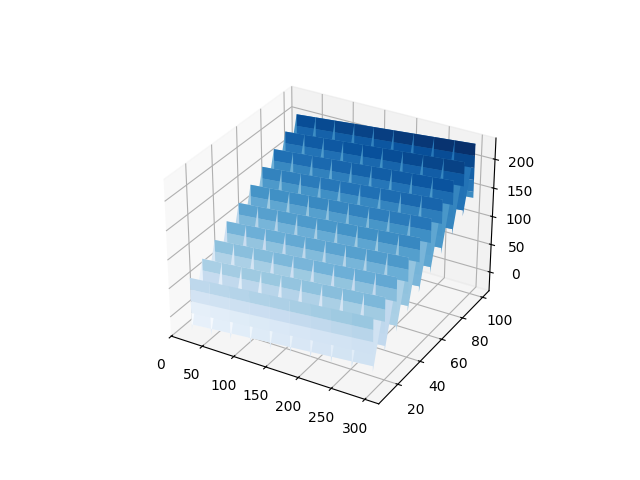

In [33]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, cmap=cm.Blues)

<Axes: xlabel='pH', ylabel='pO'>

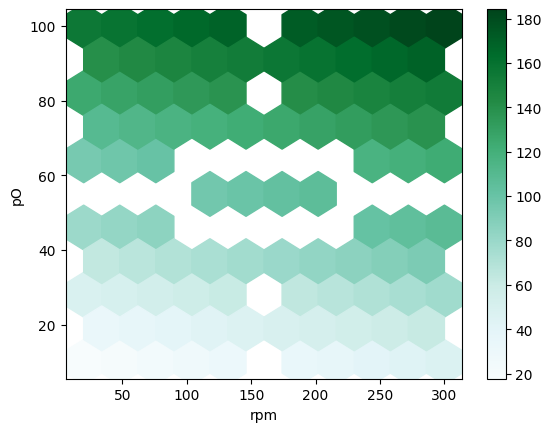

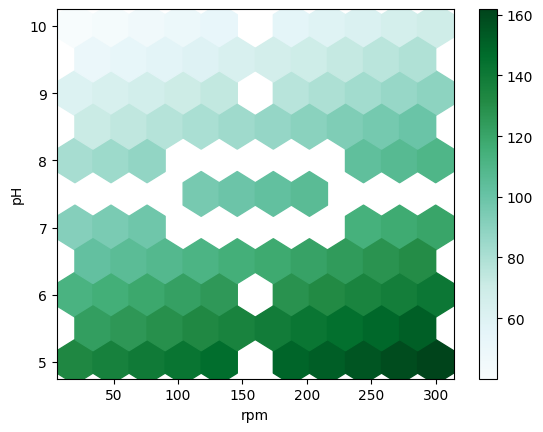

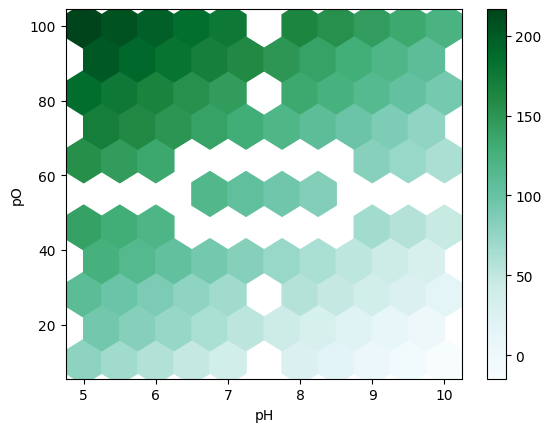

In [ ]:
ress.plot(kind='hexbin', x='rpm', y='pO', C='titer', gridsize=10)
ress.plot(kind='hexbin', x='rpm', y='pH', C='titer', gridsize=10)
ress.plot(kind='hexbin', x='pH', y='pO', C='titer', gridsize=10)

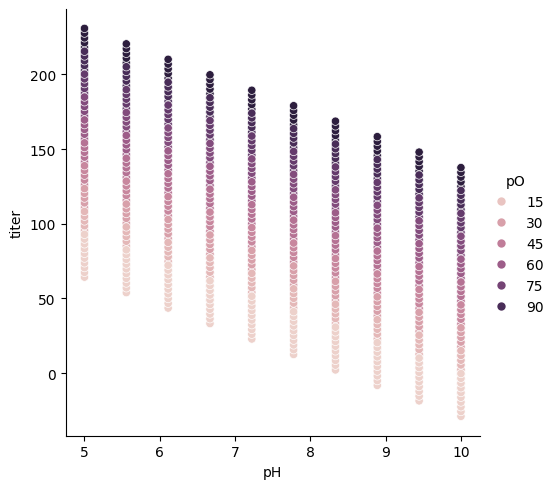

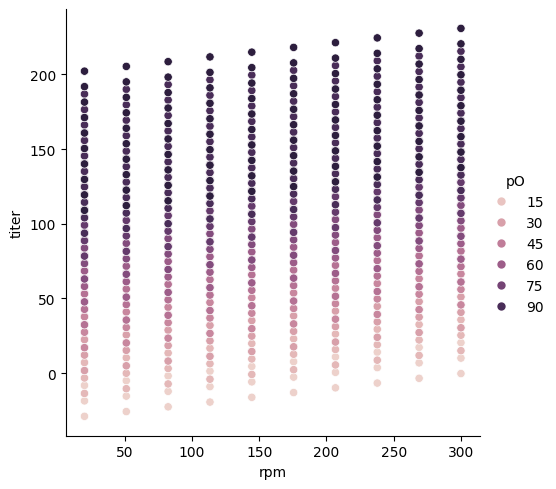

In [30]:
sns.relplot(ress, x='pH', y='titer', hue='pO')
sns.relplot(ress, x='rpm', y='titer', hue='pO')

In [114]:
https://stackoverflow.com/questions/28324545/adding-a-4th-variable-to-a-3d-plot-in-python

SyntaxError: invalid decimal literal (96451151.py, line 1)